In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
pd.set_option('display.max_columns', 500)
df = pd.read_csv('titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked'], axis='columns', inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   Fare      891 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 34.9+ KB


In [5]:
df.dropna(subset='Age', inplace=True)

In [6]:
df.Sex.replace({'male': 1, 'female': 0}, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8920\3582545346.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Sex.replace({'male': 1, 'female': 0}, inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8920\3582545346.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.Sex.replace({'male

In [7]:
df.describe()

,Survived,Pclass,Sex,Age,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.406162,2.236695,0.634454,29.699118,34.694514
std,0.491460,0.838250,0.481921,14.526497,52.918930
min,0.000000,1.000000,0.000000,0.420000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,8.050000
50%,0.000000,2.000000,1.000000,28.000000,15.741700
75%,1.000000,3.000000,1.000000,38.000000,33.375000
max,1.000000,3.000000,1.000000,80.000000,512.329200


### ==> Decision Tree don't need Scaling

In [8]:
X = df.drop('Survived', axis='columns')
Y = df.Survived

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=100)
X_train.shape, X_test.shape

((571, 4), (143, 4))

In [10]:
np.unique(Y_train, return_counts=True)

(array([0, 1], dtype=int64), array([330, 241], dtype=int64))

# Decision Tree Classifier

In [11]:
DTC = DecisionTreeClassifier(random_state=42)
DTC.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

In [12]:
DTC.score(X_train,Y_train), DTC.score(X_test,Y_test)

(0.9824868651488616, 0.7692307692307693)

### ==> Overfitting

In [13]:
Yp_test = DTC.predict(X_test)
cm = confusion_matrix(Y_test, Yp_test)
report = classification_report(Y_test, Yp_test)
cm, print(report)

              precision    recall  f1-score   support

           0       0.85      0.79      0.82        94
           1       0.64      0.73      0.69        49

    accuracy                           0.77       143
   macro avg       0.75      0.76      0.75       143
weighted avg       0.78      0.77      0.77       143



(array([[74, 20],
        [13, 36]], dtype=int64),
 None)

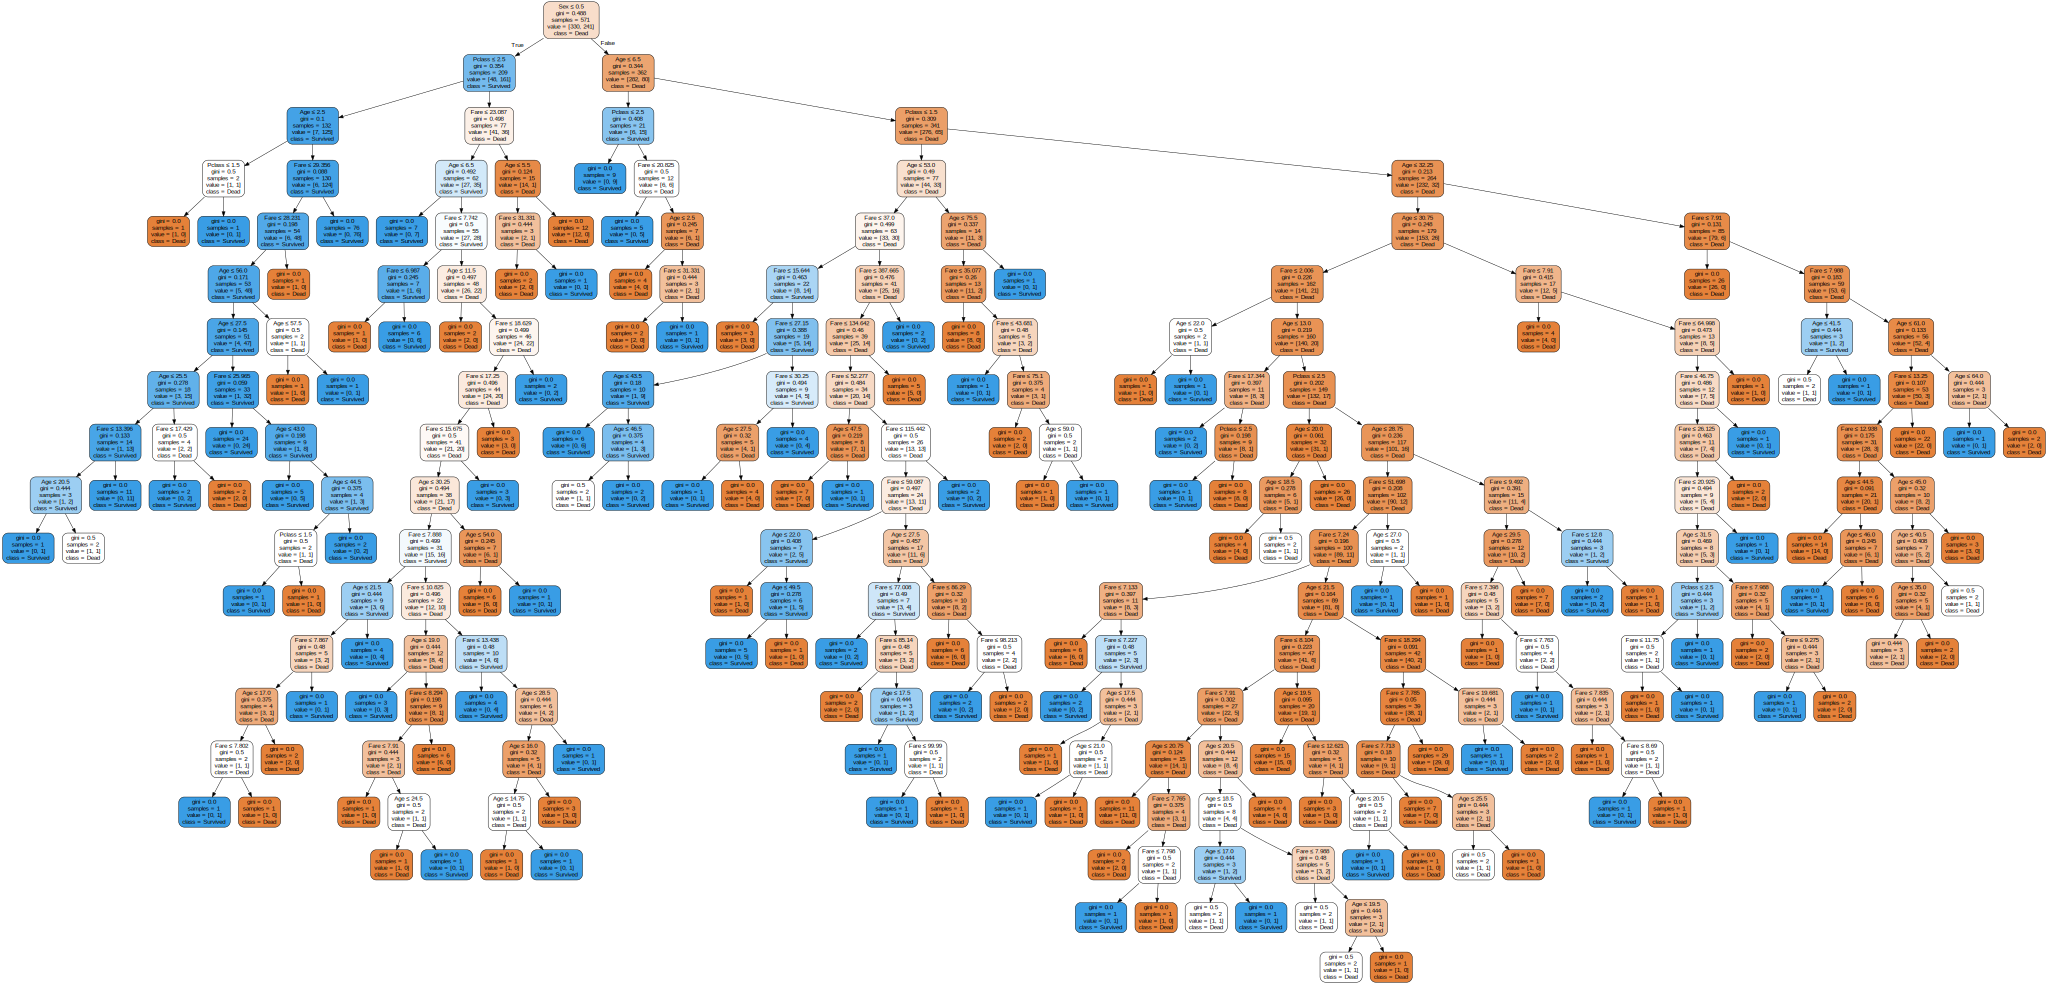

<Figure size 1500x1500 with 0 Axes>

In [14]:
import graphviz
dot = export_graphviz(DTC, feature_names=X.columns, class_names=['Dead', 'Survived'], 
                      impurity=True, filled=True, rounded=True, special_characters=True)

plt.figure(figsize=(15,15))
graph = graphviz.Source(dot)
graph

# Pruning Tree to Avoid Overfitting - Cost Complexity Pruning

**Pruning Path:** As you increase the alpha value from 0 to higher values, the decision tree will prune more branches to become simpler. Each alpha value in `ccp_alphas` corresponds to a step in this pruning process.

**Impurity Values:** Each impurity value in the `impurities` array corresponds to the total impurity of the tree's leaves at the corresponding alpha value in `ccp_alphas`.


In [15]:
path = DTC.cost_complexity_pruning_path(X_train, Y_train)
path

{'ccp_alphas': array([0.        , 0.00035026, 0.00045868, 0.00052539, 0.00055383,
        0.00058377, 0.00058377, 0.00060045, 0.00070053, 0.00082093,
        0.00084912, 0.00091735, 0.00103782, 0.00105079, 0.00107722,
        0.00108971, 0.00110917, 0.00116754, 0.00116754, 0.00116754,
        0.00120603, 0.00131349, 0.00131349, 0.00140105, 0.0014146 ,
        0.00150113, 0.00154833, 0.00157618, 0.00157618, 0.0015849 ,
        0.00163456, 0.00163456, 0.00172437, 0.00174253, 0.00175131,
        0.00175131, 0.00175131, 0.00183471, 0.00186518, 0.00186807,
        0.00186864, 0.0020361 , 0.00232867, 0.00239465, 0.00270481,
        0.0028021 , 0.00285122, 0.00300225, 0.00340331, 0.00347497,
        0.00357232, 0.00524161, 0.0060045 , 0.01048533, 0.01936317,
        0.03915397, 0.14005409]),
 'impurities': array([0.01809691, 0.01879743, 0.01971479, 0.02076557, 0.02242708,
        0.02301085, 0.02359462, 0.02419507, 0.02559612, 0.02723798,
        0.03063446, 0.03155182, 0.03466526, 0.03886842

**Example Interpretation**

- At `ccp_alpha = 0.0`, the impurity is `0.01809691`. This represents the impurity of the fully grown tree without any pruning.

- As `ccp_alpha` increases to `0.00035026`, the impurity slightly increases to `0.01879743`. This means some branches have been pruned, simplifying the tree, but increasing the impurity because some mixed nodes are now leaves.

- This process continues, with `ccp_alpha` and corresponding impurities recorded at each step. As alpha values increase, more branches are pruned, and the impurity values generally increase.

- The final alpha value is `0.14005409`, and the corresponding impurity is `0.48785275`. This represents the simplest tree in this pruning path, likely with very few branches and high impurity.


In [16]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Cost Complexity Pruning Path')

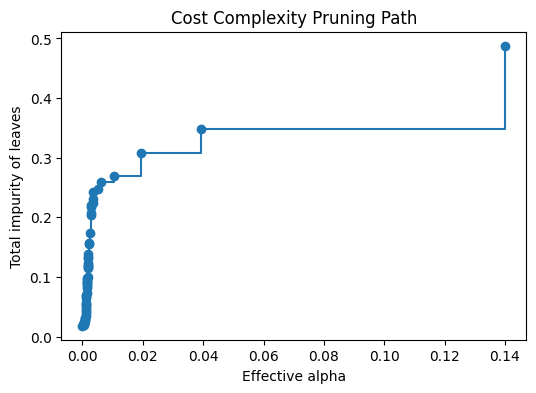

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of leaves")
plt.title("Cost Complexity Pruning Path")

In [18]:
train_scores = []
test_scores = []
for i in ccp_alphas:
    dtc = DecisionTreeClassifier(ccp_alpha=i, random_state=42)
    dtc.fit(X_train, Y_train)
    
    train_score = dtc.score(X_train, Y_train)
    test_score = dtc.score(X_test, Y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

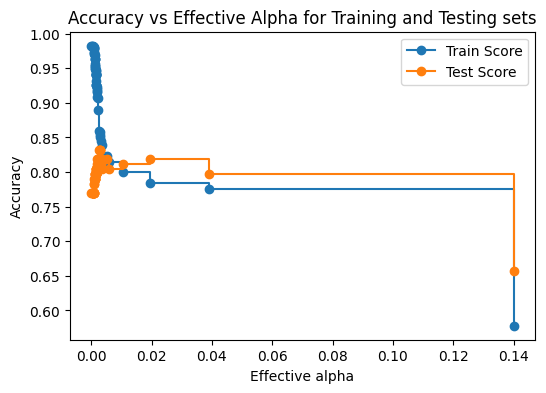

In [19]:
plt.figure(figsize=(6, 4))

plt.plot(ccp_alphas, train_scores, marker='o', label='Train Score', drawstyle='steps-post')
plt.plot(ccp_alphas, test_scores, marker='o', label='Test Score', drawstyle='steps-post')

plt.xlabel("Effective alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Effective Alpha for Training and Testing sets")
plt.legend()

In [20]:
optimal_alpha_range = ccp_alphas[(ccp_alphas >= 0.002) & (ccp_alphas <= 0.01)]
optimal_alpha_range

array([0.0020361 , 0.00232867, 0.00239465, 0.00270481, 0.0028021 ,
       0.00285122, 0.00300225, 0.00340331, 0.00347497, 0.00357232,
       0.00524161, 0.0060045 ])

In [21]:
results = []
for i in optimal_alpha_range:
    dtc = DecisionTreeClassifier(random_state=0, ccp_alpha=i)
    
    cross_val = cross_val_score(dtc, X, Y, cv=5)
    mean = np.mean(cross_val)
    std = np.std(cross_val)

    results.append([i, mean, std])

In [22]:
df_results = pd.DataFrame(results, columns=['alpha', 'mean_accuracy', 'std'])
df_results.head()

,alpha,mean_accuracy,std
0,0.002036,0.799783,0.043014
1,0.002329,0.803989,0.040043
2,0.002395,0.802581,0.041359
3,0.002705,0.798395,0.044942
4,0.002802,0.802600,0.045158


<Axes: xlabel='alpha'>

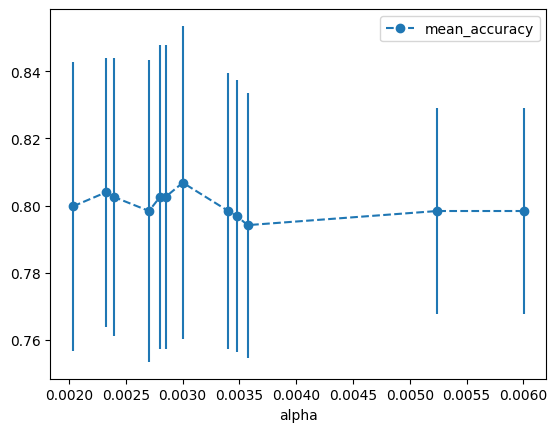

In [23]:
df_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle='--')

### ==> Optimal Alpha: 0.00300225

In [24]:
tree_pruned_optimally = DecisionTreeClassifier(random_state=42, ccp_alpha=0.00300225)
tree_pruned_optimally.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.00300225, random_state=42)

In [25]:
tree_pruned_optimally.score(X_train, Y_train), tree_pruned_optimally.score(X_test, Y_test)

(0.8528896672504378, 0.8321678321678322)

In [26]:
Yp_test = tree_pruned_optimally.predict(X_test)
cm = confusion_matrix(Y_test, Yp_test)
report = classification_report(Y_test, Yp_test)
cm, print(report)

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        94
           1       0.82      0.65      0.73        49

    accuracy                           0.83       143
   macro avg       0.83      0.79      0.80       143
weighted avg       0.83      0.83      0.83       143



(array([[87,  7],
        [17, 32]], dtype=int64),
 None)

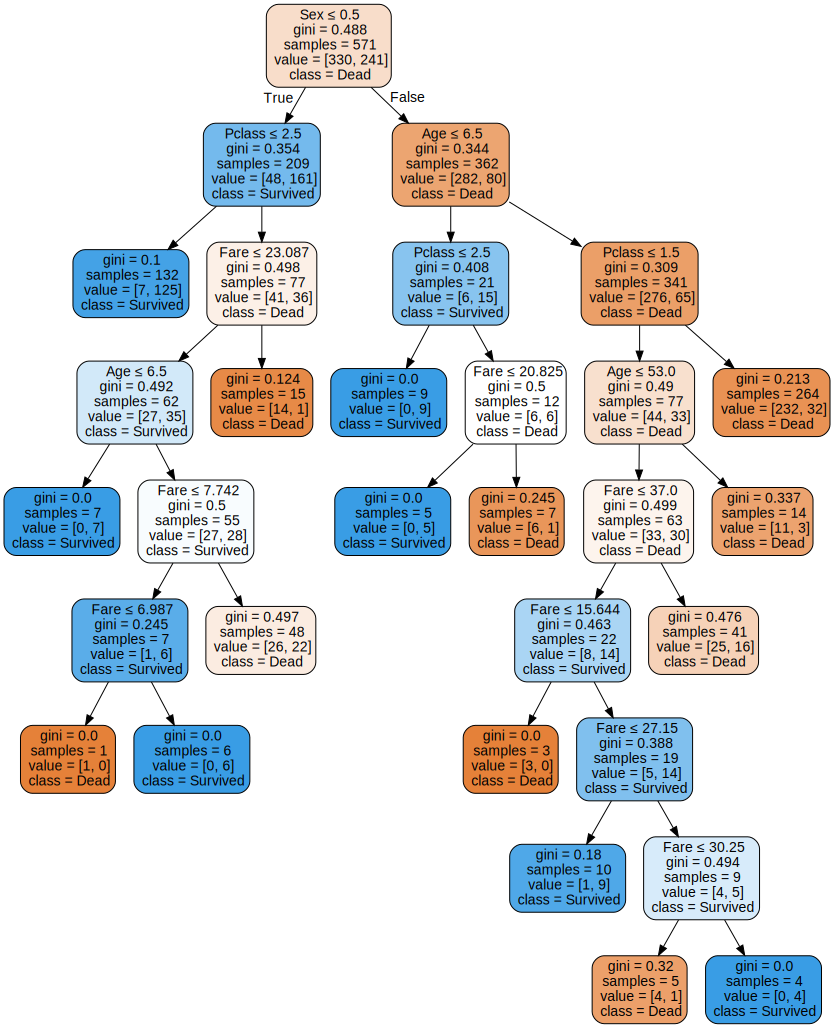

<Figure size 1500x1500 with 0 Axes>

In [27]:
import graphviz
dot = export_graphviz(tree_pruned_optimally, feature_names=X.columns, class_names=['Dead', 'Survived'], 
                      impurity=True, filled=True, rounded=True, special_characters=True)

plt.figure(figsize=(15,15))
graph = graphviz.Source(dot)
graph